### Import Packages

In [1]:
from __future__ import absolute_import, division, print_function
import matplotlib.pyplot as plt
import numpy as np

import pandas as pd
import os
import re
import scipy.io

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
import skilearn.cross_validation as spl

### Define Functions

In [2]:
def blockshaped(arr, size):
    """
    Breaks an array into smaller pieces.  Returns an array of shape (n, nrows, ncols) where
    n * size * size = arr.size

    If arr is a 2D array, the returned array should look like n subblocks with
    each subblock preserving the "physical" layout of arr.
    
    The returned array is indexed starting in the top left of the image and moving across to the right
    until hitting the edge.  At which point it continues one line down.
    
    Inputs
    arr: 2D Array to be split
    size: Size that split 2D arrays should be
    """
    h, w = arr.shape
    return (arr.reshape(h//size, size, -1, size)
               .swapaxes(1,2)
               .reshape(-1, size, size))

def crop_center(img,crop):
    """
    Crops an image into a square from the center outwards.
    
    Inputs
    img: 2D Array to be cropped
    crop: size to crop image to
    """
    # Obtain the shape of the image
    x, y, c = img.shape
    
    # The starting coordinates of the new image
    startx = x//2 - crop//2
    starty = y//2 - crop//2    
    return img[starty : starty + crop, startx : startx + crop, :]

### Import Data

In [15]:
# Optimized Data Extractor
crop_size = 1000
split_size = 100

# Define directory with matlab files
# direc = 'D:/MLdata/18-01-09d-Exp/Extract Data/'

direc  = 'D:/Nicholas_ML/18-01-09d-Exp/Extract Data/'

# Extract file names
files = [filename for filename in os.listdir(direc)][:2]

# Intialize Lists
length_index = []
split_images = []
Fn_label = []
Fs_label = []
T_label = []
log_T_label = []
block_label = []
exp_label = []

for file in files:
    print(file, end="\r")
    # Import Matlab data
    data = scipy.io.loadmat(direc + file)

    # Get data values from Matlab file
    Fn = data['Fn'].flatten()
    Fs = data['Fs'].flatten()
    T = data['T'].flatten()
    if (len(Fn) == len(Fs) == len(T)):
        length_index.append(len(Fn))
    else:
        print('ERROR: INCONSISTENT SIZE FOR FILE:', file )
        break
        
    images = data['images'].astype(np.float)

    # Pull block and experiment values from filename
    block = np.repeat(int(re.search('block(.*)_', file).group(1)), len(T))
    exp = np.repeat(int(re.search('Exp(.*).mat', file).group(1)), len(T))
    
    # Crop images to appropriate size
    cropped_images = crop_center(images, crop_size)

    for i in range(cropped_images.shape[2]):
        #Break images into smaller pieces
        #Divide by 255 to normalize data
        temp = blockshaped(cropped_images[:,:,i], split_size)/255.0
        split_images.extend(temp)
    
    # Append data to lists
    # Adjust labels to account for the splitting of images
    Fn_label.extend(np.repeat(Fn, (crop_size/split_size)**2))
    Fs_label.extend(np.repeat(Fs, (crop_size/split_size)**2))
    T_label.extend(np.repeat(T, (crop_size/split_size)**2))
    log_T_label.extend(np.repeat(np.log(T), (crop_size/split_size)**2))
    block_label.extend(np.repeat(block, (crop_size/split_size)**2)) 
    exp_label.extend(np.repeat(exp, (crop_size/split_size)**2))
    
# Convert final results into arrays
length_index = np.array(length_index)
split_images = np.array(split_images)
Fn_label = np.array(Fn_label)
Fs_label = np.array(Fs_label)
T_label = np.array(T_label)
log_T_label = np.array(log_T_label)
block_label = np.array(block_label) 
exp_label = np.array(exp_label)

### Assemble Data

In [5]:
# Assemble targets, shuffle data, and assign training and testing sets
# Note that I use the log_time values currently.
# This makes time appear linearly spaced.  Perhaps helps CNN converge faster
# targets = np.vstack((log_T_label,Fn_label,Fs_label)).T
targets = np.vstack((T_label,Fs_label)).T


# Obtain indicies for the items
ind = np.arange(split_images.shape[0])

# I want to test if the Nueral Network works well on images it has NEVER
# seen before.  As such, I am careful to remove a specifc square from
# ALL the images for testing.  That way we can make sure it isn't just learning
# features of each square in the image.



# Shuffle the indices
np.random.shuffle(ind)

# Re-arrange the data using the shuffled indices
data = split_images[ind,:,:]
targets = targets[ind,:]

# Split train and test
# Set to use 80% of data for training
train_size = round(0.8*data.shape[0])

# Seperate Data
train_data = data[:train_size,:,:]
test_data = data[train_size:,:,:]

#Seperate Labels
train_labels = targets[:train_size,:]
test_labels = targets[train_size:,:]

### Build CNN

In [7]:
def build_cnn():
    model = keras.Sequential()
    model.add(keras.layers.Conv2D(32, kernel_size=(8, 8), strides=(1, 1),
                     activation='tanh',
                     input_shape=(100,100,1)))
    model.add(keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(keras.layers.Conv2D(64, (8, 8), activation='tanh'))
    model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(128, activation='relu'))
    model.add(keras.layers.Dense(2))
    
    optimizer = tf.keras.optimizers.RMSprop(0.001)

    model.compile(loss='mean_squared_error',
                optimizer=optimizer,
                metrics=['mean_absolute_error', 'mean_squared_error'])
    
    return (model)

### Train CNN

In [8]:
model = build_cnn()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [9]:
train_data = train_data.reshape(train_data.shape[0], train_data.shape[1], train_data.shape[2], 1)
test_data = test_data.reshape(test_data.shape[0], test_data.shape[1], test_data.shape[2], 1)

train_data_rand, test_data_rand, train_labels_rand, tf.test_labels_rand = spl.train_test_split(data, targets, test_size=0.25, random_state=0)


model.fit(train_data, train_labels, epochs=5)
predictions=model.predict(test_data)

Instructions for updating:
Use tf.cast instead.
Epoch 1/50
40960/40960 [==============================] - 33s 815us/sample - loss: 56867.8178 - mean_absolute_error: 107.0482 - mean_squared_error: 56867.7930
Epoch 2/50
40960/40960 [==============================] - 33s 797us/sample - loss: 55840.4991 - mean_absolute_error: 104.2564 - mean_squared_error: 55840.4453
Epoch 3/50
40960/40960 [==============================] - 31s 751us/sample - loss: 55209.6743 - mean_absolute_error: 103.0243 - mean_squared_error: 55209.6680
Epoch 4/50
40960/40960 [==============================] - 31s 760us/sample - loss: 54743.2755 - mean_absolute_error: 102.2757 - mean_squared_error: 54743.3008
Epoch 5/50
40960/40960 [==============================] - 34s 837us/sample - loss: 54338.8730 - mean_absolute_error: 101.5658 - mean_squared_error: 54338.8672
Epoch 6/50
40960/40960 [==============================] - 34s 820us/sample - loss: 53855.6774 - mean_absolute_error: 101.2077 - mean_squared_error: 53855.687

In [ ]:
model.save('test.h5')
!ls


In [ ]:
new_model = keras.models.load_model('test.h5')
print(new_model)

### Examine Results

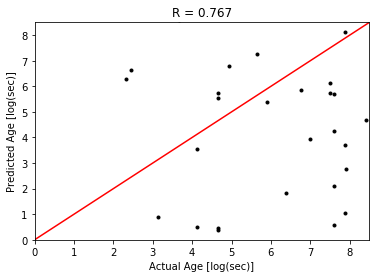

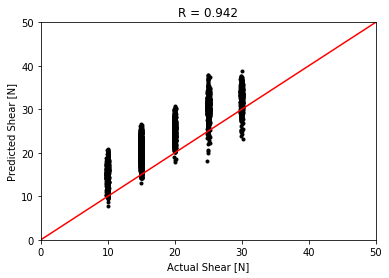

In [10]:
# Score and visualize predictions
from scipy.stats import pearsonr

actual_times = test_labels[:,0]
predicted_times = predictions[:,0]

# actual_normal = test_labels[:,1]
# predicted_normal = predictions[:,1]

actual_shear = test_labels[:,1]
predicted_shear = predictions[:,1]

plt.figure()
plt.scatter(actual_times,predicted_times, marker = ".", color = 'k')
plt.plot([0, 10], [0, 10], '-r')
plt.title('R = '+str(np.round(pearsonr(actual_times, predicted_times)[0], 3)))
plt.xlim(0,8.5)
plt.ylim(0,8.5)
plt.xlabel('Actual Age [log(sec)]')
plt.ylabel('Predicted Age [log(sec)]')
plt.savefig("Age.png", dpi = 1200, bbox_inches='tight')
plt.show()

# plt.figure()
# plt.scatter(actual_normal,predicted_normal, marker = ".", color = 'k')
# plt.title('R = '+str(np.round(pearsonr(actual_normal, predicted_normal)[0], 3)))
# plt.plot([80, 100], [80, 100], '-r')
# plt.xlim(89.5,90.5)
# plt.ylim(89.5,90.5)
# plt.xlabel('Actual Normal [N]')
# plt.ylabel('Predicted Normal [N]')
# plt.savefig("Normal.png", di = 1200, bbox_inches='tight')
# plt.show()

plt.figure()
plt.scatter(actual_shear,predicted_shear, marker = ".", color = 'k')
plt.title('R = '+str(np.round(pearsonr(actual_shear, predicted_shear)[0], 3)))
plt.plot([0, 100], [0, 100], '-r')
plt.xlim(0,50)
plt.ylim(0,50)
plt.xlabel('Actual Shear [N]')
plt.ylabel('Predicted Shear [N]')
plt.savefig("Shear.png", dpi = 1200, bbox_inches='tight')
plt.show()